# Network Analysis

In [179]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [180]:
data_path = "data/"

In [181]:
decades = list(range(1840, 2000, 10))
mentions_fr = pd.read_pickle(data_path + "mentions_fr.pkl")
mentions_de = pd.read_pickle(data_path + 'mentions_de.pkl')
mentions_all = pd.concat([mentions_fr, mentions_de])

In [182]:
mentions_all.head()

,entity,name,lArticleOffset,rArticleOffset,language,id,qid,article,newspaper,date,year,decade,agency
14,org.ent.pressagency.AFP,AFP,63,66,fr,JDG-1951-08-08-a-i0095:63:66:newsag:bert_fr,Q40464,JDG-1951-08-08-a-i0095,JDG,1951-08-08,1951,1950,AFP
15,org.ent.pressagency.Reuters,Reuter,249,255,fr,JDG-1951-08-08-a-i0095:249:255:newsag:bert_fr,Q130879,JDG-1951-08-08-a-i0095,JDG,1951-08-08,1951,1950,Reuters
16,org.ent.pressagency.AFP,AFP,141,144,fr,GDL-1976-12-22-a-i0117:141:144:newsag:bert_fr,Q40464,GDL-1976-12-22-a-i0117,GDL,1976-12-22,1976,1970,AFP
17,org.ent.pressagency.AFP,A . F . P .,62,73,fr,JDG-1951-12-24-a-i0090:62:73:newsag:bert_fr,Q40464,JDG-1951-12-24-a-i0090,JDG,1951-12-24,1951,1950,AFP
23,org.ent.pressagency.AFP,AFP,54,57,fr,JDG-1958-06-07-a-i0239:54:57:newsag:bert_fr,Q40464,JDG-1958-06-07-a-i0239,JDG,1958-06-07,1958,1950,AFP


## Create Basic Graph

### Edge Attributes

In [183]:
edge_attrs = mentions_all[['date', 'year', 'decade', 'language']].to_dict(orient='records')
edge_list = list(zip(mentions_all['newspaper'], mentions_all['agency'], edge_attrs))
edge_list[:5]

[('JDG',
  'AFP',
  {'date': '1951-08-08', 'year': 1951, 'decade': 1950, 'language': 'fr'}),
 ('JDG',
  'Reuters',
  {'date': '1951-08-08', 'year': 1951, 'decade': 1950, 'language': 'fr'}),
 ('GDL',
  'AFP',
  {'date': '1976-12-22', 'year': 1976, 'decade': 1970, 'language': 'fr'}),
 ('JDG',
  'AFP',
  {'date': '1951-12-24', 'year': 1951, 'decade': 1950, 'language': 'fr'}),
 ('JDG',
  'AFP',
  {'date': '1958-06-07', 'year': 1958, 'decade': 1950, 'language': 'fr'})]

### Create Graph

In [184]:
G = nx.MultiGraph()
keys = G.add_edges_from(edge_list)

### Node Attributes

In [185]:
#bipartite graph -> create information which part a node belongs to
agencies = mentions_all['agency'].unique()
newspapers = mentions_all['newspaper'].unique()

bipartite_attrs = dict(  list(zip( agencies, [{"bipartite": 0}] * len(agencies) )) +
                        list(zip( newspapers, [{"bipartite": 1}] * len(newspapers) ))
                        )
bipartite_attrs

{'AFP': {'bipartite': 0},
 'Reuters': {'bipartite': 0},
 'ATB-SDA': {'bipartite': 0},
 'AP': {'bipartite': 0},
 'UP-UPI': {'bipartite': 0},
 'unk': {'bipartite': 0},
 'Havas': {'bipartite': 0},
 'Wolff': {'bipartite': 0},
 'Extel': {'bipartite': 0},
 'DPA': {'bipartite': 0},
 'Stefani': {'bipartite': 0},
 'DNB': {'bipartite': 0},
 'DDP-DAPD': {'bipartite': 0},
 'ag': {'bipartite': 0},
 'Kipa': {'bipartite': 0},
 'SPK-SMP': {'bipartite': 0},
 'TASS': {'bipartite': 0},
 'Europapress': {'bipartite': 0},
 'JDG': {'bipartite': 1},
 'GDL': {'bipartite': 1},
 'IMP': {'bipartite': 1},
 'LLE': {'bipartite': 1},
 'EXP': {'bipartite': 1},
 'LSE': {'bipartite': 1},
 'LCE': {'bipartite': 1},
 'luxwort': {'bipartite': 1},
 'indeplux': {'bipartite': 1},
 'avenirgdl': {'bipartite': 1},
 'luxembourg1935': {'bipartite': 1},
 'GAV': {'bipartite': 1},
 'LBP': {'bipartite': 1},
 'LCR': {'bipartite': 1},
 'LCG': {'bipartite': 1},
 'courriergdl': {'bipartite': 1},
 'LES': {'bipartite': 1},
 'lunion': {'bipar

In [186]:
nx.set_node_attributes(G, bipartite_attrs)
G.nodes.data()

NodeDataView({'JDG': {'bipartite': 1}, 'AFP': {'bipartite': 0}, 'Reuters': {'bipartite': 0}, 'GDL': {'bipartite': 1}, 'IMP': {'bipartite': 1}, 'ATB-SDA': {'bipartite': 0}, 'AP': {'bipartite': 0}, 'UP-UPI': {'bipartite': 0}, 'LLE': {'bipartite': 1}, 'unk': {'bipartite': 0}, 'Havas': {'bipartite': 0}, 'EXP': {'bipartite': 1}, 'Wolff': {'bipartite': 0}, 'Extel': {'bipartite': 0}, 'LSE': {'bipartite': 1}, 'LCE': {'bipartite': 1}, 'luxwort': {'bipartite': 1}, 'indeplux': {'bipartite': 1}, 'avenirgdl': {'bipartite': 1}, 'luxembourg1935': {'bipartite': 1}, 'DPA': {'bipartite': 0}, 'GAV': {'bipartite': 1}, 'LBP': {'bipartite': 1}, 'LCR': {'bipartite': 1}, 'Stefani': {'bipartite': 0}, 'DNB': {'bipartite': 0}, 'LCG': {'bipartite': 1}, 'courriergdl': {'bipartite': 1}, 'LES': {'bipartite': 1}, 'lunion': {'bipartite': 1}, 'LNF': {'bipartite': 1}, 'SDT': {'bipartite': 1}, 'luxland': {'bipartite': 1}, 'LTF': {'bipartite': 1}, 'LLS': {'bipartite': 1}, 'EDA': {'bipartite': 1}, 'FZG': {'bipartite': 1}, 

## Make "Subgraphs"

In [187]:
ag_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
np_nodes = set(G) - ag_nodes
ag_nodes

{'AFP',
 'AP',
 'ATB-SDA',
 'DDP-DAPD',
 'DNB',
 'DPA',
 'Europapress',
 'Extel',
 'Havas',
 'Kipa',
 'Reuters',
 'SPK-SMP',
 'Stefani',
 'TASS',
 'UP-UPI',
 'Wolff',
 'ag',
 'unk'}

In [188]:
def retrieve_freq(row, col_keep, node):
    #lookup dictionary in row[col_keep]
    return row[col_keep][row[node]]


def create_subgraph_edgelist(df, col_keep = 'agency', col_drop = 'newspaper', time_granularity = 'year'):
    #count occurrence of agency mentions per year and newspaper
    df_grouped = df.groupby([col_drop, time_granularity]).agg({col_keep: Counter}).reset_index()
    #get all possible combinations of agency tuples per year and newspaper
    df_grouped['comb'] = df_grouped[col_keep].apply(lambda x: list(combinations(x.keys(),2)))
    #explode list of tuples to one tuple per row
    df_grouped = df_grouped.explode('comb').dropna()
    df_grouped['node1'] = df_grouped['comb'].apply(lambda x: x[0])
    df_grouped['node2'] = df_grouped['comb'].apply(lambda x: x[1])
    df_grouped = df_grouped.drop(columns='comb')
    #keep frequency of agency mentions per year and newspaper
    df_grouped['freq_node1'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node1'), axis=1)
    df_grouped['freq_node2'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node2'), axis=1)

    #create edgelist
    edge_attrs = df_grouped[[time_granularity, 'freq_node1', 'freq_node2']].to_dict(orient='records')
    edge_list = list(zip(df_grouped['node1'], df_grouped['node2'], edge_attrs))

    return edge_list

In [189]:
G_agencies_edges = create_subgraph_edgelist(mentions_all, col_keep='agency', col_drop='newspaper')
print(f"Length of Edgelist: {len(G_agencies_edges)}, first entries: {G_agencies_edges[:10]} ...")
G_agencies = nx.MultiGraph()
_ = G_agencies.add_edges_from(G_agencies_edges)

Length of Edgelist: 15640, first entries: [('unk', 'ag', {'year': 1887, 'freq_node1': 4, 'freq_node2': 1}), ('unk', 'DNB', {'year': 1887, 'freq_node1': 4, 'freq_node2': 1}), ('unk', 'Havas', {'year': 1887, 'freq_node1': 4, 'freq_node2': 1}), ('ag', 'DNB', {'year': 1887, 'freq_node1': 1, 'freq_node2': 1}), ('ag', 'Havas', {'year': 1887, 'freq_node1': 1, 'freq_node2': 1}), ('DNB', 'Havas', {'year': 1887, 'freq_node1': 1, 'freq_node2': 1}), ('unk', 'Havas', {'year': 1888, 'freq_node1': 1, 'freq_node2': 1}), ('SPK-SMP', 'ATB-SDA', {'year': 1889, 'freq_node1': 1, 'freq_node2': 1}), ('SPK-SMP', 'DNB', {'year': 1889, 'freq_node1': 1, 'freq_node2': 1}), ('SPK-SMP', 'ag', {'year': 1889, 'freq_node1': 1, 'freq_node2': 1})] ...


In [190]:
G_newspapers_edges = create_subgraph_edgelist(mentions_all, col_keep='newspaper', col_drop='agency')
print(f"Length of Edgelist: {len(G_newspapers_edges)}, first entries: {G_newspapers_edges[:10]} ...")
G_newspaper = nx.MultiGraph()
_ = G_newspaper.add_edges_from(G_newspapers_edges)

Length of Edgelist: 13832, first entries: [('LES', 'GDL', {'year': 1917, 'freq_node1': 1, 'freq_node2': 3}), ('LES', 'LLE', {'year': 1917, 'freq_node1': 1, 'freq_node2': 2}), ('LES', 'EXP', {'year': 1917, 'freq_node1': 1, 'freq_node2': 1}), ('GDL', 'LLE', {'year': 1917, 'freq_node1': 3, 'freq_node2': 2}), ('GDL', 'EXP', {'year': 1917, 'freq_node1': 3, 'freq_node2': 1}), ('LLE', 'EXP', {'year': 1917, 'freq_node1': 2, 'freq_node2': 1}), ('IMP', 'GDL', {'year': 1919, 'freq_node1': 1, 'freq_node2': 7}), ('IMP', 'LLE', {'year': 1919, 'freq_node1': 1, 'freq_node2': 1}), ('GDL', 'LLE', {'year': 1919, 'freq_node1': 7, 'freq_node2': 1}), ('GDL', 'LLE', {'year': 1920, 'freq_node1': 2, 'freq_node2': 11})] ...


## First Exploration

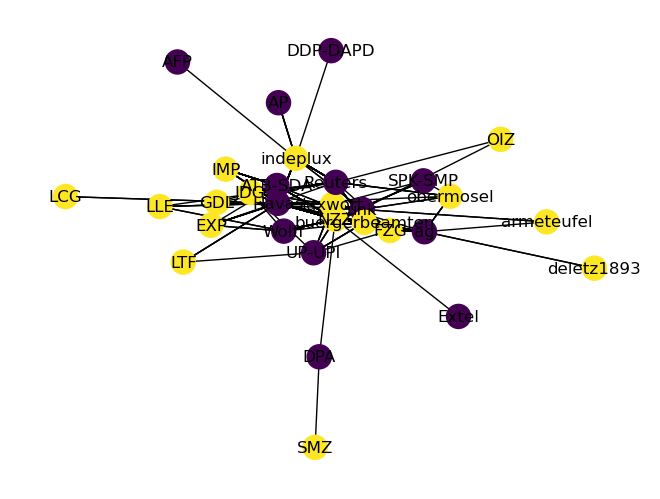

In [191]:
G_1900 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1900])
nx.draw(G_1900, with_labels=True, node_color=[node[1]['bipartite'] for node in G_1900.nodes.data()])

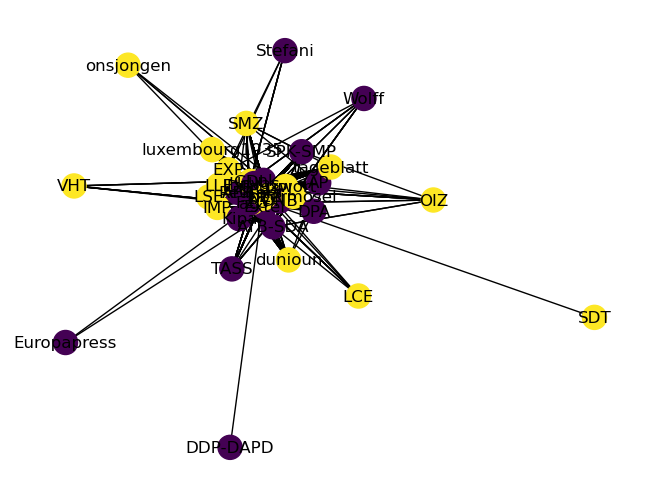

In [192]:
G_1940 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1940])
nx.draw(G_1940, with_labels=True, node_color=list(dict(G_1940.nodes.data("bipartite")).values()))

## Saving Graphs

In [193]:
nx.write_gexf(G, "data/G_np_ag.gexf")
nx.write_gexf(G_newspaper, "data/G_np.gexf")
nx.write_gexf(G_agencies, "data/G_ag.gexf")